## Introduction to images

This notebook is a mismash of the following two links

- http://juliaimages.github.io/latest/arrays_colors.html
- https://evizero.github.io/Augmentor.jl/images/

with some of my own tests.

In [12]:
using Images
using FileIO
using TestImages
using Statistics
using BenchmarkTools

#### Image hash

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1664


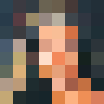

In [2]:
img = testimage("fabio_color_256.png");
img_resized = imresize(img, 8, 8)

In [4]:
using Statistics
img_resized_gray = Gray.(img_resized)
mean_image = mean((Gray.(img_resized)));
mean_image.val

0.4098039215686275

In [5]:
aux = img_resized_gray .< mean_image

8×8 BitMatrix:
 1  1  1  1  1  1  1  1
 1  1  0  0  0  1  1  1
 1  1  1  0  0  0  1  1
 1  0  1  0  0  0  1  1
 1  0  1  0  0  0  1  1
 1  0  1  0  0  0  1  1
 0  0  1  1  0  0  0  1
 0  1  1  1  0  0  0  0

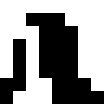

In [6]:
Gray.(aux)

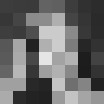

In [7]:
img_resized_gray

The hash of the image is 

In [8]:
reinterpret(aux, (1,length(aux)))

1×64 BitMatrix:
 1  1  1  1  1  1  0  0  1  1  1  0  0  …  1  1  0  0  1  1  1  1  1  1  1  0

In [13]:
@benchmark a = aux[:]

BenchmarkTools.Trial: 10000 samples with 656 evaluations.
 Range (min … max):  188.898 ns …   7.418 μs  ┊ GC (min … max): 0.00% … 96.42%
 Time  (median):     191.438 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   197.192 ns ± 158.237 ns  ┊ GC (mean ± σ):  1.93% ±  2.34%

    ▃█▅▄▁                                                        
  ▁▅██████▆▃▃▃▃▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  189 ns           Histogram: frequency by time          214 ns <

 Memory estimate: 96 bytes, allocs estimate: 2.

In [14]:
@benchmark a = reinterpret(aux, (1,length(aux)))

BenchmarkTools.Trial: 10000 samples with 759 evaluations.
 Range (min … max):  167.765 ns …   6.343 μs  ┊ GC (min … max): 0.00% … 96.13%
 Time  (median):     171.003 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   179.004 ns ± 198.306 ns  ┊ GC (mean ± σ):  3.64% ±  3.19%

   ▃▅▇███▇▆▅▅▄▄▃▄▂▂▂▂▂▁▁                                        ▂
  ▇██████████████████████████▇█▇▅█▇▆▆▇▆▇▇▆▆▅▆▆▇▆▅▆▆▇▅▅▅▅▅▅▅▃▄▅▅ █
  168 ns        Histogram: log(frequency) by time        199 ns <

 Memory estimate: 144 bytes, allocs estimate: 3.

In [15]:
@benchmark reinterpret(aux, (length(aux), 1))

BenchmarkTools.Trial: 10000 samples with 759 evaluations.
 Range (min … max):  167.490 ns …   6.568 μs  ┊ GC (min … max): 0.00% … 96.34%
 Time  (median):     170.675 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   179.225 ns ± 201.505 ns  ┊ GC (mean ± σ):  3.69% ±  3.19%

  ▁▄▇███▇▆▅▅▅▄▄▃▂▃▂▂▁▁▁▁▁▁▁                                     ▂
  ██████████████████████████▇██▇▇▇▇▇▇▇▇▇▆▇▇▇▆▆▇▆▇▆▅▆▅▅▆▅▅▄▆▇▅▆▅ █
  167 ns        Histogram: log(frequency) by time        202 ns <

 Memory estimate: 144 bytes, allocs estimate: 3.

Note that with this hash one can compute a fast distances.

To sum up, the average hash can be computed as follows

In [16]:
function average_hash(image, hash_size=8)
    img_resized = imresize(image, hash_size, hash_size)
    img_resized_gray = Gray.(img_resized)
    mean_image_intensity = mean(img_resized_gray).val
    bit_matrix = img_resized_gray .> mean_image_intensity
    #bit_vector = reinterpret(bit_matrix, (1, length(bit_matrix)))
    #return bit_vector
    return bit_matrix
end

average_hash (generic function with 2 methods)

In [17]:
eltype(average_hash(img))

Bool

In [18]:
average_hash(img)

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  1  1  1  0  0  0
 0  0  0  1  1  1  0  0
 0  1  0  1  1  1  0  0
 0  1  0  1  1  1  0  0
 0  1  0  1  1  1  0  0
 1  1  0  0  1  1  1  0
 1  0  0  0  1  1  1  1

#### Fast distances between hashes

In [15]:
using BenchmarkTools

In [16]:
function hamming(x,y)
    res = 0
    for (x_k,y_k) in zip(x,y)
        res += x_k != y_k
    end
    return res
end

hamming (generic function with 1 method)

In [17]:
aux = img_resized_gray .< mean_image
x = reshape(aux, (length(aux)));
@benchmark hamming($x, $x)

BenchmarkTools.Trial: 10000 samples with 980 evaluations.
 Range (min … max):  61.947 ns … 204.167 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     62.415 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.280 ns ±   4.156 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃██▅             ▁▅▄▁               ▃▂▁                    ▂
  ▄▅█████▇▇▆▇▇▇▅▆▅▆▆▆█████▇▇▇█▇▇█▆▇█▇██▇███▇█▇▆▇▇▅▆▄▄▆▄▅▆▇▄▅▁▅ █
  61.9 ns       Histogram: log(frequency) by time      68.8 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [18]:
x = reinterpret(aux, (1,length(aux)))
@benchmark hamming($x, $x)

BenchmarkTools.Trial: 10000 samples with 980 evaluations.
 Range (min … max):  62.967 ns … 131.633 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     63.180 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.370 ns ±   1.388 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ███▆                   ▁▁                                   ▂
  ▇█████▆▅▅▆▅▅▅▆▅▅▅▄▄▅▆▆▇▇███▆▆▅▅▅▅▅▅▄▅▁▅▄▅▆▆▄▅▅▅▃▅▆▇▆▅▅▆▄▄▄▆▅ █
  63 ns         Histogram: log(frequency) by time        68 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

Why is a float64 verctor hamming distance faster than with a bitvector?

In [19]:
function hamming2(x,y)
    res = 0
    @inbounds for i in 1:length(x)
        res += x[i] != y[i]
    end
    return res
end

hamming2 (generic function with 1 method)

In [20]:
x = reinterpret(aux, (1,length(aux)))
@benchmark hamming2($x,$x)

BenchmarkTools.Trial: 10000 samples with 992 evaluations.
 Range (min … max):  37.802 ns … 131.930 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     37.887 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.131 ns ±   2.539 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇██▆▅               ▁                    ▁                   ▂
  █████▇▆▅▅▆▆▇▅▅▆▆▆▅▆▆█▇▇█▆▇▅▆▄▄▅▅▆▄▁▃▅▄▅▄▆█▆▇▅▅▆▃▅▄▅▃▄▆▅▆▄▁▃▃ █
  37.8 ns       Histogram: log(frequency) by time      41.4 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

It is still slower than float64 vector

In [21]:
x = reinterpret(aux, (1,length(aux)))
x = x[:];

In [22]:
@benchmark hamming2($x, $x)

BenchmarkTools.Trial: 10000 samples with 992 evaluations.
 Range (min … max):  37.761 ns … 53.385 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     37.887 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.154 ns ±  0.763 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▇█▇▄▅▂                 ▁▄▄▃ ▁                     ▁▁       ▂
  ████████▅▄▃▆▁▅▄▁▄▄▄▄▄▅▄▆██████▆▅▅▅▅▅▅▆▅▅▄▆▅▅▅▁▅▆▅▄████▇▅▅▆▆ █
  37.8 ns      Histogram: log(frequency) by time      40.7 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
hamming_bitwise(x::UInt,y::UInt) = count_ones(x ⊻ y)

hamming_bitwise (generic function with 1 method)

In [24]:
hamming_bitwise(-1,1)

LoadError: MethodError: no method matching hamming_bitwise(::Int64, ::Int64)

We can compute the hamming distance between two has values as follows:

In [25]:
x_int = 31
@btime aux = hamming_bitwise($x_int, $x_int)

LoadError: MethodError: no method matching hamming_bitwise(::Int64, ::Int64)

In [26]:
@benchmark aux = hamming_bitwise($x_int, $x_int)

LoadError: MethodError: no method matching hamming_bitwise(::Int64, ::Int64)

In [58]:
hamming_bitwise(0,3), hamming_bitwise(0,2)

(2, 1)

In [59]:
hamming_bitwise(UInt64(0), typemax(UInt64))

64

In [22]:
x_uint = UInt64(0)
y_uint = typemax(UInt64)

@benchmark hamming_bitwise($x_uint, $y_uint)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  2.166 ns … 119.792 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.291 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.364 ns ±   1.772 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁     █     ▇     ▇     ▃     ▂     ▂     ▁            ▂
  ▄▁▁▁▁█▇▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▅ █
  2.17 ns      Histogram: log(frequency) by time      2.58 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

#### Reinterpret BitVector to integer

Since our BitVectors have dimension 64 we can reinterprent them as UInt64 and leverage bit oeprators at int level

In [168]:
aux = img_resized_gray .< mean_image
bitvec = BitVector(aux[:]);

In [157]:
function reinterpret_bits_as_int(iterable_over_bits)
    z = zero(UInt64)
    for k in eachindex(iterable_over_bits)
        z = (z <<1) | iterable_over_bits[k]
    end
    return z
end

@assert reinterpret_bits_as_int(BitVector([0,0,1,1])) == 3
@assert reinterpret_bits_as_int(BitVector([0,1,1,0])) == 6

In [164]:
reinterpret_bits_as_int(BitVector([1,0,0,0,0])) == 2^(5-1)

true

In [81]:
x_int = reinterpret_bits_as_int(aux)
typeof(x_int)

UInt64

In [155]:
@benchmark reinterpret_bits_as_int(aux)

BenchmarkTools.Trial: 10000 samples with 968 evaluations.
 Range (min … max):  77.781 ns … 172.091 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     80.966 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   81.984 ns ±   3.566 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

         █ ▂▂                                                   
  ▁▁▂▄▂▂▅█▇███▄▃▃▃▃▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  77.8 ns         Histogram: frequency by time         96.5 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [167]:
reinterpret_bits_as_int(bitvec)

0x03ff691f041c31c3

#### Why do we care about rewritting a bit of booleans into a single int?

In [256]:
x_int = reinterpret_bits_as_int(aux)
y_int = reinterpret_bits_as_int(aux)
hamming_bitwise(x_int, y_int), hamming_bitwise(x_int, x_int), hamming_bitwise(y_int, y_int)

(0, 0, 0)

In [27]:
@benchmark aux = hamming_bitwise($x_int, $x_int)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  2.083 ns … 18.125 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.208 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.209 ns ±  0.222 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▇       █▂                                  
  ▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▂ ▂
  2.08 ns        Histogram: frequency by time        2.38 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [246]:
bitstring(hamming_bitwise(UInt64(0), typemax(UInt64)))

"0000000000000000000000000000000000000000000000000000000001000000"

In [248]:
hamming_bitwise(1,2)

2

Note that this is more efficient than operating from the bitvector

In [31]:
function hamming_bitvector(x::T,y::T) where T
    res = 0
    @inbounds @fastmath @simd for k in eachindex(x)
        res += x[k] ⊻ y[k]
    end
    return res
end

hamming_bitvector (generic function with 1 method)

In [35]:
@benchmark aux = hamming_bitvector($x, $x)

BenchmarkTools.Trial: 10000 samples with 993 evaluations.
 Range (min … max):  37.344 ns … 116.188 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     37.513 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.244 ns ±   2.637 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▁▂▂▅▂▁▁▁▃▁▁▁                                               ▁
  ██████████████▇▇▇▇▇▇▇▆▇▆▆▆▅▆▅▅▅▆▅▄▁▄▅▄▅▅▅▅▄▄▅▅▅▅▅▄▄▆▄▅▄▅▅▁▅▅ █
  37.3 ns       Histogram: log(frequency) by time      51.6 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

#### Example: How many pairwise comparisons could we do with hashes of 64 bits?

In [40]:
n_examples = 1_000_000
database = rand(UInt64,n_examples);
q = database[6534]
threshold = 10

10

In [41]:
function check_for_almost_equal(q, database, threshold = 10)
    
    results = []
    for (k,x) in enumerate(database)
       if hamming_bitwise(x, q) < threshold
            push!(results, k)
        end
    end
    return results
end 

check_for_almost_equal (generic function with 2 methods)

In [42]:
threshold = 3
@benchmark check_for_almost_equal($q, $database, $threshold)

BenchmarkTools.Trial: 7239 samples with 1 evaluation.
 Range (min … max):  673.375 μs …  1.184 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     683.375 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   687.352 μs ± 13.407 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▃▆██▇▇▆▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁ ▁ ▁                              ▂
  ▅▅▇██████████████████████████▇████▇▇▇▇▇▇▇▇▆▇▆▆▆▆▃▆▄▆▅▅▆▆▄▆▅▅ █
  673 μs        Histogram: log(frequency) by time       736 μs <

 Memory estimate: 144 bytes, allocs estimate: 3.

#### Reinterpret BitVector or Array[bool] as int

In [43]:
aux_bits = BitVector(Bool[0, 0, 0, 0, 0, 0, 1, 1])
reinterpret(UInt8, aux_bits)

8-element reinterpret(UInt8, ::BitVector):
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x01
 0x01

In [83]:
function reinterpret_bits_as_int(iterable_over_bits)
    z = zero(UInt64)
    for k in eachindex(iterable_over_bits)
        z = (z <<1) | iterable_over_bits[k]
    end
    return z
end

reinterpret_bits_as_int (generic function with 1 method)

In [84]:
aux_bits = BitVector(Bool[0, 0, 0, 0, 0, 0, 1, 1])

@benchmark reinterpret_bits_as_int(aux_bits)

BenchmarkTools.Trial: 10000 samples with 990 evaluations.
 Range (min … max):  43.939 ns … 122.096 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     44.444 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   44.954 ns ±   1.790 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▅█▅▃       ▂▄▁        ▁▂▁▁                                 ▁
  ▅▅████▆▆▇▇▅▆▇███▆▇▆▆▇▆▆▇█████▆▆▆▆▅▃▄▅▅▅▃▅▃▂▄▅▄▃▄▄▄▃▃▅▅▅▃▄▃▂▄ █
  43.9 ns       Histogram: log(frequency) by time      51.7 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [85]:
reinterpret_bits_as_int(aux_bits)

0x0000000000000003

In [86]:
function reinterpret_bits_as_int(iterable_over_bits)
    z = 0b00000000
     for k in eachindex(iterable_over_bits)
        z = (z <<1) | iterable_over_bits[k]
    end
    return z
end

reinterpret_bits_as_int (generic function with 1 method)

In [88]:
function reinterpret_bits(::Type{T}, iterable_over_bits) where {T <: Base.BitUnsigned}
    z = zero(T)
     for k in eachindex(iterable_over_bits)
        z = (z <<1) | iterable_over_bits[k]
    end
    return z
end

reinterpret_bits (generic function with 1 method)

In [89]:
@benchmark reinterpret_bits($UInt8, $aux_bits)

BenchmarkTools.Trial: 10000 samples with 842 evaluations.
 Range (min … max):  144.942 ns … 203.830 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     145.981 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   147.606 ns ±   3.472 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▆██▆▄▄▃▃▅▂  ▂▂▃▄▃▃▄▅▃▂▂▁ ▂ ▁       ▁ ▁▁                      ▂
  ██████████████████████████████████████████▇▆▇▇▆▆▆▅▅▅▄▅▅▅▅▅▄▅▃ █
  145 ns        Histogram: log(frequency) by time        161 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [90]:
bit_reinterpret(A::AbstractArray{Bool}, T=UInt8) = reduce( (a, b) -> T(2) * a + b, A)

bit_reinterpret (generic function with 2 methods)

In [91]:
b = BitArray([1,1,0,1,0,0,1,1]);

In [92]:
@benchmark bit_reinterpret($b)

BenchmarkTools.Trial: 10000 samples with 22 evaluations.
 Range (min … max):  948.864 ns …  3.038 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     965.909 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   981.103 ns ± 57.116 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▅▇▇█▆▄▂ ▁▃▃▂▃▃▃▃▁▂▁▁▁ ▁                                    ▂
  ▅██████████████████████████▆▇▆▆▅▃▄▅▄▂▅▄▄▅▃▂▅▅▅▅▄▆▆▆▇█▇▇▆▆▆▄▄ █
  949 ns        Histogram: log(frequency) by time      1.15 μs <

 Memory estimate: 96 bytes, allocs estimate: 6.

In [93]:
reinterpret_bits_as_int(aux_bits)

0x03

In [94]:
aux_bits

8-element BitVector:
 0
 0
 0
 0
 0
 0
 1
 1

In [95]:
function bit_reinterpret(::Type{T}, itr) where {T <: Base.BitUnsigned}
           y = zero(T)
           for (i, x) in enumerate(itr)
               if i > 8 *sizeof(y)
                   error("Too many elements")
               end
               xT = T(convert(Bool, x))
               y = (y << 1) | xT
           end
           y
       end

bit_reinterpret (generic function with 3 methods)

In [96]:
@benchmark bit_reinterpret(UInt8,aux_bits)

BenchmarkTools.Trial: 10000 samples with 903 evaluations.
 Range (min … max):  122.924 ns … 275.702 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     123.938 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   125.352 ns ±   4.710 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃██▇▃    ▁▃▄▄▃▂       ▁▁                                      ▂
  ██████▇▇███████▇██████████▇█▇▆▆▆▅▄▅▄▆▆▆▆▆▆▅▄▅▅▅▆▄▄▅▅▆▅▅▅▅▄▅▄▅ █
  123 ns        Histogram: log(frequency) by time        145 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [176]:
function bit_reinterpret2(::Type{T}, itr) where {T <: Base.BitUnsigned}
           y = zero(T)
           for (i, x) in enumerate(itr)
               #xT = T(convert(Bool, x))
               y = (y << 1) | x
           end
           y
       end

bit_reinterpret2 (generic function with 1 method)

In [177]:
bit_reinterpret2(UInt8, aux_bits)

0x03

In [185]:
z = 0b0000000

z = (z | 0b1) <<2

0x04

In [187]:
z = 0b0000000
z

0x00

In [209]:
z| 0b1111

0x0f

In [179]:
z

0x04

In [180]:
aux = 3%unsigned(Int8)

0x03

## Testing speed

https://github.com/JohannesBuchner/imagehash/blob/master/imagehash/__init__.py

In [181]:
#img_resized

In [182]:
@btime img1=load("./images/logo1.png");

  28.159 ms (58 allocations: 29.22 MiB)


In [234]:
@btime average_hash(img1);

  1.292 μs (4 allocations: 576 bytes)


### Average hash details


The imagehash python library converts to grayscale using

```

    When translating a color image to greyscale (mode "L"),
    the library uses the ITU-R 601-2 luma transform::
    
        L = R * 299/1000 + G * 587/1000 + B * 114/1000
    
    The default method of converting a greyscale ("L") or "RGB"
    image into a bilevel (mode "1") image uses Floyd-Steinberg
    dither to approximate the original image luminosity levels. If
    dither is :data:`NONE`, all values larger than 127 are set to 255 (white),
    all other values to 0 (black). To use other thresholds, use the
    :py:meth:`~PIL.Image.Image.point` method.
```

About  Floyd-Steinberg: https://surma.dev/things/ditherpunk/

In [197]:
function average_hash(image, hash_size=8)
    img_resized = imresize(image, hash_size, hash_size)
    img_resized_gray = Gray.(img_resized)

    # We can compute the mean over the gray image or the mean over the colors and aggregate them
    mean_image_intensity = mean(img_resized_gray).val
    bit_matrix = img_resized_gray .> mean_image_intensity
    
    # reinterpret(aux, (1,length(aux)))
    return bit_matrix
end

average_hash (generic function with 2 methods)

In [238]:
using ImageTransformations
import ImageTransformations.Linear as Linear

In [231]:
hash_size = 8
image = load("./images/logo1.png");
img_resized = imresize(image, hash_size, hash_size, method=Linear())
img_resized_gray = Gray.(img_resized)
#mean_image_intensity = mean(img_resized_gray).val
mean_image_intensity = mean(img_resized)

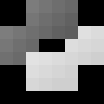

In [218]:
img_resized_gray

In [219]:
img_uint8 = reinterpret(UInt8, img_resized_gray)

8×8 reinterpret(UInt8, ::Array{Gray{N0f8},2}):
 0x00  0x00  0x7c  0x75  0x6e  0x68  0x00  0x00
 0x00  0x00  0x76  0x6e  0x68  0x61  0x00  0x00
 0x7d  0x76  0x6f  0x69  0x61  0x5d  0xe0  0xdb
 0x77  0x6f  0x69  0x00  0x00  0xdd  0xd9  0xd6
 0x70  0x6a  0xe2  0xdf  0xdb  0xd7  0xd3  0xcf
 0x00  0x00  0xdd  0xd9  0xd5  0xd1  0x00  0x00
 0x00  0x00  0xd7  0xd3  0xcf  0xcf  0x00  0x00
 0x00  0x00  0x00  0x00  0x00  0x00  0x00  0x00

In [220]:
img_uint8 = reinterpret(UInt8, img_resized_gray)

8×8 reinterpret(UInt8, ::Array{Gray{N0f8},2}):
 0x00  0x00  0x7c  0x75  0x6e  0x68  0x00  0x00
 0x00  0x00  0x76  0x6e  0x68  0x61  0x00  0x00
 0x7d  0x76  0x6f  0x69  0x61  0x5d  0xe0  0xdb
 0x77  0x6f  0x69  0x00  0x00  0xdd  0xd9  0xd6
 0x70  0x6a  0xe2  0xdf  0xdb  0xd7  0xd3  0xcf
 0x00  0x00  0xdd  0xd9  0xd5  0xd1  0x00  0x00
 0x00  0x00  0xd7  0xd3  0xcf  0xcf  0x00  0x00
 0x00  0x00  0x00  0x00  0x00  0x00  0x00  0x00

In [221]:
h =  average_hash(img1)
reinterpret(h, (1,length(h)))

1×64 BitMatrix:
 0  0  1  1  1  0  0  0  0  0  1  1  1  …  1  0  0  0  0  0  1  1  1  0  0  0

In [223]:
img1=load("./images/logo1.png")
average_hash(img1)

8×8 BitMatrix:
 0  0  1  1  1  1  0  0
 0  0  1  1  1  1  0  0
 1  1  1  1  1  0  1  1
 1  1  1  0  0  1  1  1
 1  1  1  1  1  1  1  1
 0  0  1  1  1  1  0  0
 0  0  1  1  1  1  0  0
 0  0  0  0  0  0  0  0

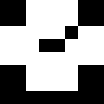

In [224]:
Gray.(h)